In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, constants
import migen as mg

%matplotlib inline

In [2]:
class CosSin:
    """cos(z), sin(z) generator numerical model"""
    def __init__(self, z=18, x=15, zl=9, xd=3, a=0.):
        self.z = z  # total phase depth, unsigned
        self.x = x  # x width, leave out sign bit
        if zl is None:
            zl = z - 3
        assert zl >= 0
        self.zl = zl  # LUT phase bits, LUT address width
        assert xd >= 0
        self.xd = xd  # derivative coefficient bit width in LUT
        self.a = a  # dither amplitude
        self.z_max = 1 << z
        print("LUT: {} deep, {} wide".format(zl, 2*x + 2*xd))
        # LUT phase values
        # use mid point of the phase bins to avoid needing an additional entry for pi/4
        self._zl = (np.arange(1 << zl) + .5)/(1 << zl)*np.pi/4
        self.x_max = (1 << x) - 1
        # LUT sin/cos data
        cs = np.round(self.x_max*np.exp(1j*self._zl))
        self.c, self.s = cs.real.astype(np.int32), cs.imag.astype(np.int32)
        if xd:
            # derivative LUT, includes the 2pi/(1<<3) factor
            csd = np.round(np.pi/4*(1 << xd)*np.exp(1j*self._zl))
            self.cd, self.sd = csd.real.astype(np.int32), csd.imag.astype(np.int32)

    def xy(self, z):
        """Calculate cos(z) and sin(z)"""
        z = z + self.a*np.random.triangular(-1, 0, 1, len(z))
        z = np.mod(np.round(z).astype(np.int32), self.z_max)
        # 3 MSBs: octant
        z0, z1, z2 = [((z >> self.z - 1 - i) & 1) for i in range(3)]
        # LSBs: phase, map into first octant
        z = z & ~(7 << self.z - 3)
        # z2: pi/2 - z or z
        z = np.where(z2, ((1 << self.z - 3) - 1) - z, z)
        # do LUT lookup
        zk = self.z - 3 - self.zl
        zl = z >> zk
        c, s = self.c[zl], self.s[zl]
        if self.xd:
            # derivative lookup
            zd = (z & ((1 << zk) - 1)) - (1 << zk - 1)
            sd, cd = zd*self.sd[zl], zd*self.cd[zl]
            zq = self.z - 3 - self.x + self.xd
            if zq > 0:  # introduce rounding bias
                sd, cd = (sd + (1 << zq - 1)) >> zq, (cd + (1 << zq - 1)) >> zq
            else:
                sd, cd = sd << -zq, cd << -zq
            c, s = c - sd, s + cd
        # unmap octant bits
        # z1 ^ z2: swap sin/cos
        q = z1 ^ z2
        # z0 ^ z1: invert x
        x = (1 - 2*(z0 ^ z1))*np.where(q, s, c)
        # z0: invert y
        y = (1 - 2*z0)*np.where(q, c, s)
        return x, y

    def xy_err(self):
        """Return maximum quadrature error, rms magnitude error, and max magnitude error"""
        z = np.arange(self.z_max)
        x, y = self.xy(z)
        xy = x + 1j*y
        xye = xy - self.x_max*np.exp(2j*np.pi/self.z_max*(z + .5))
        xye2 = np.absolute(xye)
        #assert xye.mean() < 1e-3
        return np.fabs(np.r_[xye.real, xye.imag]).max(), (xye2**2).mean()**.5, xye2.max()
          
# minimal verification
c = CosSin(z=13, x=13, zl=None, xd=0)
assert np.diff(c.s).max() == 7., np.diff(c.s).max()
ce = c.xy_err()
assert ce[0] <= .5, ce
assert ce[1] <= .5, ce
assert ce[2] < 1, ce

LUT: 10 deep, 26 wide


LUT: 9 deep, 36 wide
iq max err, rms err, mag max err (3.0799251776679739, 1.0784633420207483, 3.2423751194309745)
-104.882909557


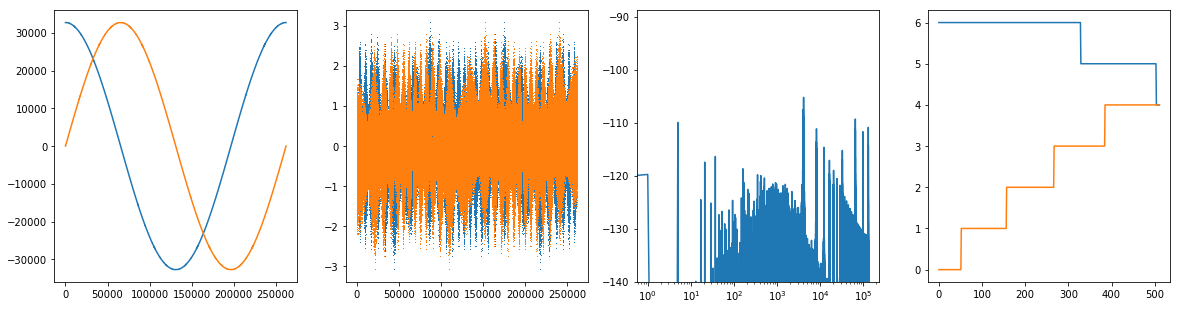

In [3]:
#c = CosSin()
#c = CosSin(z=16, zl=8, x=13, xd=5)
#c = CosSin(z=20, zl=10, x=21, xd=13)  # -135 dBc ??
#c = CosSin(z=20, zl=9, x=14, xd=4)  # -109 dBc
#c = CosSin(z=20, zl=10, x=15, xd=3)  # -111 dBc, 10deep,2*18wide BRAM, 7*3 multiplier
#c = CosSin(z=19, zl=9, x=14, xd=4)  # -107 dBc
# good 16 bit
c = CosSin(z=18, zl=9, x=15, xd=3)  # -105 dBc, 9deep,2*(15+3) wide BRAM, 2 (18-9-3)*3 multipliers
# excellent 16 bit
#c = CosSin(z=20, zl=9, x=15, xd=5)  # -116 dBc, 9deep,2*(15+5) wide BRAM, 2 (20-9-3)*5 multipliers
#c = CosSin(z=13, zl=9, x=12, xd=3)  # migen test
#c = CosSin(z=24, zl=9, x=18, xd=18)  # -132 dBc
#c = CosSin(z=19, zl=9, x=15, xd=3, a=32.)  # dither
# good 14 bit
#c = CosSin(z=17, zl=6, x=13, xd=5)  # -98 dBc, 6deep,2*(13+5)wide BRAM, 2 (17-6-3)*5 multipliers
#c = CosSin(z=18, zl=9, x=15, xd=3)  # -97 dBc, 9deep,2*(14+4)wide BRAM, 2 (18-9-3)*3 multipliers

print("iq max err, rms err, mag max err", c.xy_err())

z = np.arange(1 << c.z)
x, y = c.xy(z)
xy = x + 1j*y
xy0 = c.x_max*np.exp(2j*np.pi/(1 << c.z)*(z + .5))
xy_err = xy - xy0
xy_err_p = 20*np.log10(np.absolute(np.fft.fft(xy_err)/c.x_max/len(xy_err)))
print(xy_err_p[1:].max())

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].plot(xy.real)
ax[0].plot(xy.imag)

ax[1].plot(xy_err.real, ",")
ax[1].plot(xy_err.imag, ",")

ax[2].plot(xy_err_p[:len(xy_err_p)//2])
ax[2].set_ylim(-140, None)
ax[2].set_xscale("log")

if c.xd:
    ax[3].plot(c.cd)
    ax[3].plot(c.sd)

-106.839198911


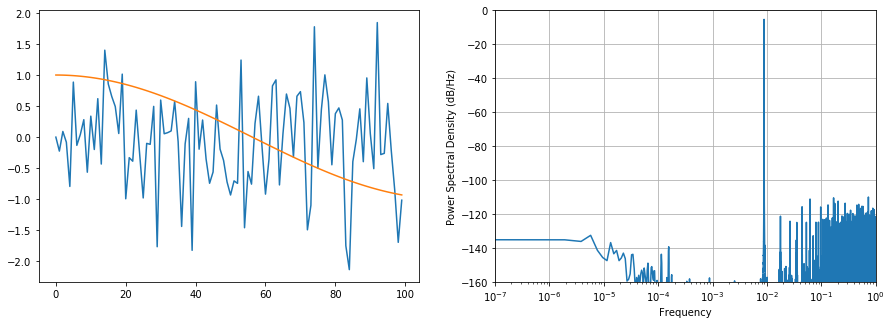

In [4]:
# play around with the numerical model

self = c
f = 0x01234567  # FTW
ftw = 32  # FTW width
i = np.arange(1 << 20, dtype=np.int64)
x, y = self.xy(np.arange(self.z_max))
z = ((i*f) & ((1 << ftw) - 1))
zi = z >> ftw - self.z
p = (x[zi] + 1j*y[zi])/c.x_max
q = np.exp(2j*np.pi*z/(1 << ftw))
sfdr = 20*np.log10(np.absolute(np.fft.fft(p - q)/len(p)).max())
print(sfdr)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot((p - q)[:100].real*c.x_max)
ax[0].plot(p.real[:100])
#ax[1].psd((p - q), NFFT=len(p))
ax[1].psd(p/len(p)**.5, NFFT=len(p))
ax[1].set_ylim(-160, 0)
#ax[1].plot(np.fft.fftfreq(*p.shape), np.absolute(np.fft.fft(p))/len(p))
#ax[1].set_ylim(1e-7, 1.)
#ax[1].set_yscale("log")
ax[1].set_xlim(1e-7, 1)
ax[1].set_xscale("log")
ff = f/(1 << ftw)*2
#plt.xlim(ff - 1e-3, ff + 1e-3)

In [22]:
class CosSinGen(mg.Module):
    """cos(z), sin(z) generator using a block ROM and linear interpolation

    For background information about an alternative way of computing
    trigonometric functions without multipliers and large ROM, see:

    P. K. Meher et al., "50 Years of CORDIC: Algorithms, Architectures, and Applications"
    in IEEE Transactions on Circuits and Systems I: Regular Papers, vol. 56, no. 9,
    pp. 1893-1907, Sept. 2009. doi: 10.1109/TCSI.2009.2025803
    https://eprints.soton.ac.uk/267873/1/tcas1_cordic_review.pdf
    
    For other implementations of trigonometric function generators, see

    https://www.xilinx.com/products/intellectual-property/dds_compiler.html#documentation
    https://www.intel.com/content/dam/altera-www/global/en_US/pdfs/literature/ug/ug_nco.pdf

    The implementation is as follows:

    1. Extract the 3 MSBs and save for later unmapping.
    2. Map the remaining LSBs into the first octant [0, pi/4]
       (conditional phase flip)
    3. Use the coarse `zl` MSBs of the first octant phase to look up 
       cos(z), sin(z), cos'(z), sin'(z) in block ROM.
    4. Interpolate with the residual LSBs as cos(z + dz) = cos(z) + dz*cos'(z).
    5. Unmap the octant (cos sign flip, sin sign flip, cos/sin swap).

    The default values for the constructor parameters yield a 105 dBc
    SFDR generator (19 bit phase that uses one 9x36 bit block ROM (one
    RAMB18xx in read-only SDP mode on several Xilinx architectures),
    two 3x6 bit multipliers (fabric), and two 16 bit adders.
    
    The output is combinatorial and it helps to add another pipeline
    stage.

    Multiplication by a amplitude scaling factor (`a*cos(z)`)
    and generation of the phase input (e.g. a phase accumulator)
    is to be implemented elsewhere.
    """
    def __init__(self, z=18, x=15, zl=9, xd=3):
        self.latency = 2
        self.z = mg.Signal(z)  # input phase
        self.x = mg.Signal((x + 1, True), reset_less=True)  # output cos(z)
        self.y = mg.Signal((x + 1, True), reset_less=True)  # output sin(z)

        ###

        if zl is None:
            zl = z - 3
        assert zl >= 0
        # LUT phase values
        zls = (np.arange(1 << zl) + .5)/(1 << zl)*np.pi/4
        # LUT cos/sin
        init = [(int(_.real) | int(_.imag) << x)
                for _ in np.round(((1 << x) - 1)*np.exp(1j*zls))]
        mem_layout = [("x", x), ("y", x)]
        if xd:
            # derivative LUT, includes the 2pi/(1 << xd) scaling factor
            init = [i | (int(j.real) << 2*x) | (int(j.imag) << 2*x + xd)
                    for i, j in zip(
                        init, np.round(np.pi/4*(1 << xd)*np.exp(1j*zls)))]
            mem_layout.extend([("xd", xd), ("yd", xd)])
        lut = mg.Record(mem_layout, reset_less=True)
        assert len(init) == 1 << zl
        print("CosSin LUT {} bit deep, {} bit wide".format(zl, len(lut)))
        self.mem = mg.Memory(len(lut), 1 << zl, init=init)
        assert all(_ >= 0 for _ in self.mem.init)
        assert all(_ < (1 << len(lut)) for _ in self.mem.init)
        mem_port = self.mem.get_port()
        self.specials += self.mem, mem_port
        # 3 MSBs: octant
        # LSBs: phase, maped into first octant
        za = mg.Signal(z - 3)
        # LUT lookup
        xl, yl = lut.x, lut.y
        if xd:  # apply linear interpolation
            zk = z - 3 - zl
            zd = mg.Signal((zk, True), reset_less=True)
            self.comb += zd.eq(za[:zk] - (1 << zk - 1))
            zd = self.pipe(zd, 2)
            zq = z - 3 - x + xd
            assert zq > 0
            # add a rounding bias
            xl = xl - (((zd*lut.yd) + (1 << zq - 1)) >> zq)
            yl = yl + (((zd*lut.xd) + (1 << zq - 1)) >> zq)
        # unmap octant, pipe for BRAM adr and data registers
        zq = self.pipe(mg.Cat(self.z[-3] ^ self.z[-2],
                              self.z[-2] ^ self.z[-1], self.z[-1]), 2)
        # intermediate unmapping signals
        x1 = mg.Signal((x + 1, True))
        y1 = mg.Signal((x + 1, True))
        x2 = mg.Signal((x + 1, True))
        y2 = mg.Signal((x + 1, True))
        self.comb += [
            za.eq(mg.Mux(
                self.z[-3], (1 << z - 3) - 1 - self.z[:-3], self.z[:-3])),
            mem_port.adr.eq(za[-zl:]),
            # use BRAM output data register
            lut.raw_bits().eq(self.pipe(mem_port.dat_r, 1)),
            x1.eq(xl),
            y1.eq(yl),
            x2.eq(mg.Mux(zq[0], y1, x1)),
            y2.eq(mg.Mux(zq[0], x1, y1)),
            self.x.eq(mg.Mux(zq[1], -x2, x2)),
            self.y.eq(mg.Mux(zq[2], -y2, y2)),
        ]

    def pipe(self, x, n=0):
        """Create `n` pipeline register stages for signal x
        and return final stage"""
        k = mg.value_bits_sign(x)
        x, x0 = mg.Signal(k, reset_less=True), x
        self.comb += x.eq(x0)
        for i in range(n):
            x, x0 = mg.Signal(k, reset_less=True), x
            self.sync += x.eq(x0)
        return x

    def log(self, z, xy):
        """Run self for each value of `z` and record output values into `xy`"""
        if z is None:
            z = np.arange(1 << len(self.z))
        z = np.r_[z, (0,)*self.latency]
        for i, zi in enumerate(z):
            yield self.z.eq(int(zi))
            yield
            if i >= self.latency:
                x = yield self.x
                y = yield self.y
                xy.append((x, y))

    def xy_err(self, xy):
        """Given the `xy` output of all possible `z` values,
        calculate error, maximum quadrature error, rms magnitude error,
        and maximum magnitude error."""
        z = np.arange(1 << len(self.z)) + .5
        x, y = np.array(xy).T
        xy = x + 1j*y
        x_max = (1 << 9) - 1
        x_max = max(x)
        xye = xy - x_max*np.exp(2j*np.pi*z/len(z))
        xye2 = np.absolute(xye)
        assert xye.mean() < 1e-3
        return (xye, np.fabs(np.r_[xye.real, xye.imag]).max(),
                (xye2**2).mean()**.5, xye2.max())

    def verify(self):
        """Verify that the numerical model and the gateware
        implementation are equivalent."""
        co = CosSin(z=len(self.z), x=len(self.x) - 1,
                    zl=mg.log2_int(self.mem.depth),
                    xd=self.mem.width//2 - len(self.x) + 1)
        z = np.arange(1 << len(self.z))
        xy0 = np.array(co.xy(z))
        xy = []
        mg.Simulator(self, [self.log(z, xy)]).run()
        xy = np.array(xy).T
        np.testing.assert_allclose(xy, xy0)
        return xy

In [16]:
CosSinGen(z=5, zl=2, x=2, xd=0).verify()
CosSinGen(z=5, zl=2, x=23, xd=0).verify()
CosSinGen(z=10, zl=6, x=9, xd=3).verify()
CosSinGen(z=10, zl=3, x=9, xd=3).verify()
CosSinGen(z=13, zl=9, x=12, xd=3).verify()

CosSin LUT 2 bit deep, 4 bit wide
LUT: 2 deep, 4 wide
CosSin LUT 2 bit deep, 46 bit wide
LUT: 2 deep, 46 wide
CosSin LUT 6 bit deep, 24 bit wide
LUT: 6 deep, 24 wide
CosSin LUT 3 bit deep, 24 bit wide
LUT: 3 deep, 24 wide
CosSin LUT 9 bit deep, 30 bit wide
LUT: 9 deep, 30 wide


array([[4095, 4095, 4095, ..., 4095, 4095, 4095],
       [   0,    3,    6, ...,   -6,   -3,    0]])

CosSin LUT 9 bit deep, 36 bit wide
LUT: 9 deep, 36 wide


[3.0799251776679739, 1.0784633420207483, 3.2423751194309745]

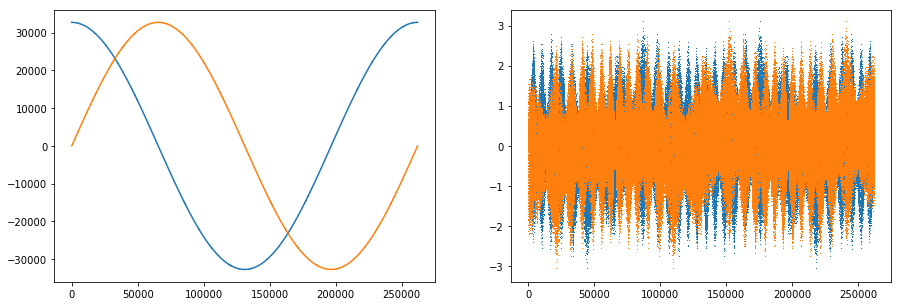

In [21]:
sincos = CosSinGen()
#sincos = CosSinGen(z=13, zl=9, x=12, xd=3)
xy = sincos.verify().T
xye, *_ = sincos.xy_err(xy)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(xy)
ax[1].plot(xye.real, ",")
ax[1].plot(xye.imag, ",")
_

In [11]:
sincos = CosSinGen()
o = mg.fhdl.verilog.convert(sincos, ios={sincos.z, sincos.x, sincos.y})
print(o.main_source)

CosSin LUT 9 bit deep, 36 bit wide
/* Machine-generated using Migen */
module top(
	input [17:0] z,
	output signed [15:0] x,
	output signed [15:0] y,
	input sys_clk,
	input sys_rst
);

wire [14:0] lut_x;
wire [14:0] lut_y;
wire [2:0] lut_xd;
wire [2:0] lut_yd;
wire [8:0] adr;
wire [35:0] dat_r;
wire [14:0] za;
wire signed [5:0] zd;
wire signed [5:0] zd_cossingen0;
reg signed [5:0] zd_cossingen1 = 6'sd0;
reg signed [5:0] zd_cossingen2 = 6'sd0;
wire [2:0] zq_cossingen0;
reg [2:0] zq_cossingen1 = 3'd0;
reg [2:0] zq_cossingen2 = 3'd0;
wire signed [15:0] x1;
wire signed [15:0] y1;
wire signed [15:0] x2;
wire signed [15:0] y2;
wire [35:0] cossingen0;
reg [35:0] cossingen1 = 36'd0;

// synthesis translate_off
reg dummy_s;
initial dummy_s <= 1'd0;
// synthesis translate_on

assign zd = (za[5:0] - 6'd32);
assign zd_cossingen0 = zd;
assign zq_cossingen0 = {z[17], (z[16] ^ z[17]), (z[15] ^ z[16])};
assign cossingen0 = dat_r;
assign za = (z[15] ? (15'd32767 - z[14:0]) : z[14:0]);
assign adr = za[1

In [24]:
# https://www.analog.com/media/en/technical-documentation/application-notes/an-1396.pdf
p = 16  # phase truncation
l = 32  # ftw width
# PPT spur power
20*np.log10(np.absolute(np.sin(np.pi/2**l)/np.sin(np.pi*(2**p - 1)/2**l)))

-96.329466071978487

-101.915077603


[2.0649886675328162, 0.918016260761643, 2.3724908050825526]

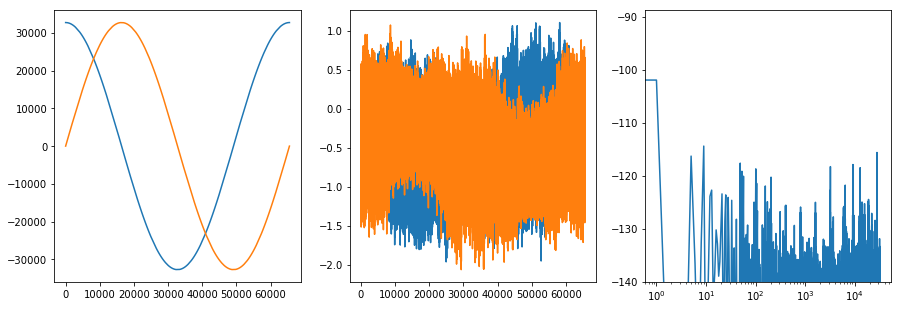

In [131]:
# Compare with migen CORDIC

from misoc.cores.cordic import Cordic
sincos = Cordic(width=16, widthz=16, guard=None, eval_mode="pipelined")

def log(self, z, xy):
    if z is None:
        z = np.arange(1 << len(self.zi))
    z = np.r_[z, (0,)*self.latency]
    yield self.xi.eq(int((1 << len(self.xi) - 1)/self.gain))
    for i, zi in enumerate(z):
        yield self.zi.eq(int(zi))
        yield
        if i >= self.latency:
            x = yield self.xo
            y = yield self.yo
            xy.append((x, y))

def xy_err(self, xy):
    z = np.arange(1 << len(self.zi)) + .5
    x, y = np.array(xy).T
    xy = x + 1j*y
    x_max = (1 << 9) - 1
    x_max = max(x)
    xye = xy - x_max*np.exp(2j*np.pi*(z - .5)/len(z))
    xye2 = np.absolute(xye)
    assert xye.mean() < 1e-3
    return (xye, np.fabs(np.r_[xye.real, xye.imag]).max(),
            (xye2**2).mean()**.5, xye2.max())

xy = []
with mg.Simulator(sincos, [log(sincos, None, xy)]) as sim:
    sim.run()
xy = np.array(xy)
xye, *_ = xy_err(sincos, xy)
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(xy)
ax[1].plot(xye.real)
ax[1].plot(xye.imag)
xy_err_p = 20*np.log10(np.absolute(np.fft.fft(xye)/c.x_max/len(xye)))
print(xy_err_p[1:].max())
ax[2].plot(xy_err_p[:len(xy_err_p)//2])
ax[2].set_ylim(-140, None)
ax[2].set_xscale("log")
_